# Speech feature visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from speech_study.audio_ptcpt_filtering import add_audio_mask
from speech_study.data_parsing import add_condition_mask
from speech_study.path_conf import loc_data_dir

In [3]:
df_feat_tot = pd.read_parquet(loc_data_dir.joinpath("df_speech_feat_tot.parquet"))

## Participant filtering

In [4]:
add_condition_mask(df_feat_tot)
add_audio_mask(df_feat_tot);

### Filtering stats

In [5]:
bad_audio = df_feat_tot.bad_audio | (df_feat_tot['HNRdBACF_sma3nz_amean'] < 0)
print("nb neutral/control removed   ", (bad_audio & (df_feat_tot.condition == "control")).sum())
print("nb negative removed          ", (bad_audio & (df_feat_tot.condition == "negative")).sum())
print("nb feedback removed          ", (bad_audio & df_feat_tot.condition.notna()).sum())

print()
print("nb neutral/control remaining ",
      (~bad_audio & (df_feat_tot.condition == "control")).sum())
print(
    "nb neutral ptctp remaining     ",
    df_feat_tot[
        (~bad_audio & (df_feat_tot.condition == "control"))
    ].participantNum.nunique(),
)
print("nb negative remaining ",
      (~bad_audio & (df_feat_tot.condition == "negative")).sum())
print(
    "nb negative ptctp remaining  ",
    df_feat_tot[
        (~bad_audio & (df_feat_tot.condition == "negative"))
    ].participantNum.nunique(),
)
print("nb feedback remaining ", (~bad_audio & df_feat_tot.condition.notna()).sum())

print()
print("total neutral  ", (df_feat_tot.condition == "control").sum())
print("total negative ", (df_feat_tot.condition == "negative").sum())

print()
print(
    "nb unique participant before                                              ",
    df_feat_tot[df_feat_tot.condition.notna()].participantNum.nunique(),
)
print(
    "nb unique participants with at least 1 feedback recording after filtering ",
    df_feat_tot[
        (~df_feat_tot.bad_audio) & (df_feat_tot.condition.notna())
        ].participantNum.nunique(),
)

nb neutral/control removed    31
nb negative removed           34
nb feedback removed           65

nb neutral/control remaining  206
nb neutral ptctp remaining      71
nb negative remaining  203
nb negative ptctp remaining   69
nb feedback remaining  409

total neutral   237
total negative  237

nb unique participant before                                               79
nb unique participants with at least 1 feedback recording after filtering  71


In [6]:
df_sex = pd.read_csv(loc_data_dir.joinpath('sex_mapping.csv'))
df_sex

,user,sex
0,1,F
1,2,F
2,3,F
3,4,M
4,5,F
...,...,...
78,79,M
79,80,F
80,81,F
81,82,F


In [7]:
unique_participants = df_feat_tot[
    (~df_feat_tot.bad_audio) & (df_feat_tot.condition.notna())
    ].participantNum.unique()
df_sex[df_sex.user.isin(unique_participants)].sex.value_counts()

F    44
M    27
Name: sex, dtype: int64

# Visualizations

## `GeMAPS`

### Condition comparison

/users/jonvdrdo/.cache/pypoetry/virtualenvs/speech-study-3baMn38--py3.8/lib/python3.8/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


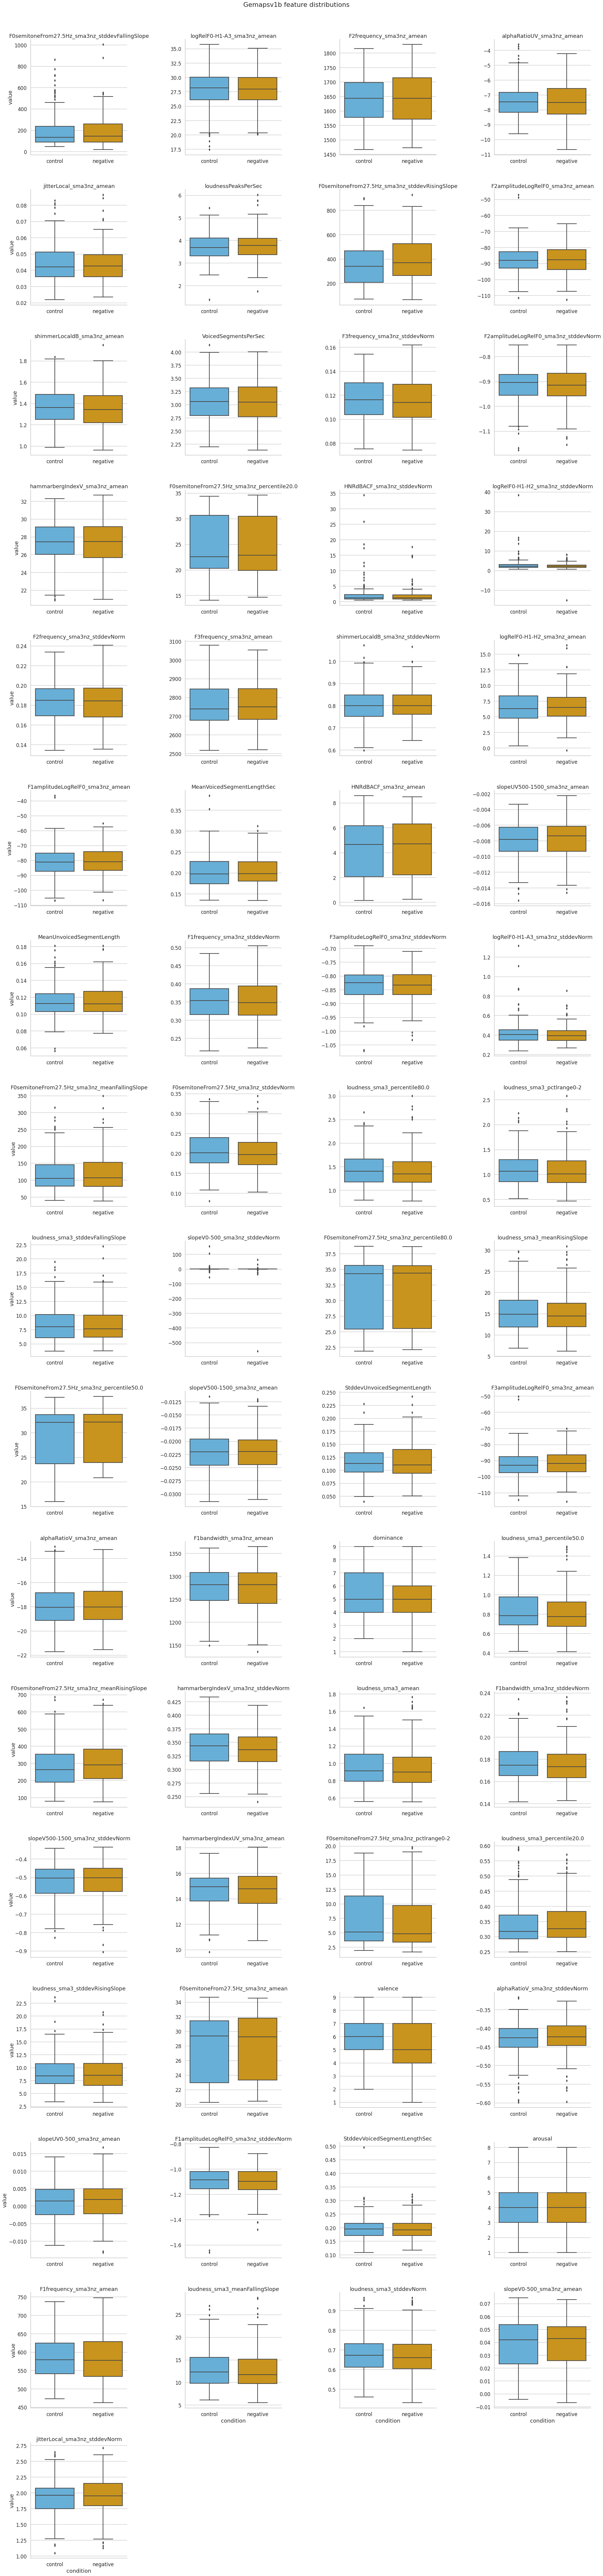

In [8]:
sns.set_context("talk")
sns.set_style("whitegrid")
g = sns.catplot(
    data=pd.melt(
        frame=df_feat_tot[
            (~df_feat_tot.bad_audio)
            & (df_feat_tot.condition.notna())
            & (df_feat_tot["HNRdBACF_sma3nz_amean"] > 0)
        ],
        id_vars=["file", "fileName", "fileNum", "condition", "participantNum"],
        value_vars=set(df_feat_tot.columns).difference(
            {
                "index",
                "file",
                "start",
                "end",
                "fileName",
                "fileNum",
                "condition",
                "bad_audio",
                "participantNum",
                # also to not visualize the LLD quantile's + counts
                *list(
                    list(df_feat_tot.filter(like="q=").columns.values)
                    + list(df_feat_tot.filter(like="nzcount").columns.values)
                ),
            }
        ),
        value_name="value",
        var_name="speech_feature",
    ),
    x="condition",
    y="value",
    col="speech_feature",
    col_wrap=4,
    height=7,
    kind="box",
    palette=["#56B4E9", "#E69F00"],
    sharey=False,
    sharex=False,
)
g.set_titles("{col_name}")
g.fig.suptitle("Gemapsv1b feature distributions", y=1.01)
plt.subplots_adjust(wspace=0.6, hspace=0.3)


### Per participant difference plot

In [9]:
# calculate the mean per participant, per condition
# TODO -> maybe use the reference values? and subtract the neutral / negative feedback
#  condition from these reference values
mean_func = (
    df_feat_tot[
        (~df_feat_tot.bad_audio)
        & (df_feat_tot.condition.notna())
        & (df_feat_tot["HNRdBACF_sma3nz_amean"] > 0)
    ]
    .groupby(["participantNum", "condition"])
    .mean()
    .reset_index()
)
mean_contr_func = mean_func[mean_func.condition == "control"].set_index(
    "participantNum"
)
mean_stress_func = mean_func[mean_func.condition == "negative"].set_index(
    "participantNum"
)
feat_cols: List[str] = list(
    set(df_feat_tot.columns).difference(
        {
            "index",
            "file",
            "start",
            "end",
            "fileName",
            "fileNum",
            "condition",
            "bad_audio",
            "participantNum",
            # also to not visualize the LLD quantile's + counts
            *list(
                list(df_feat_tot.filter(like="q=").columns.values)
                + list(df_feat_tot.filter(like="nzcount").columns.values)
            ),
        }
    )
)
#
mean_stress_min_contr_func = mean_stress_func[feat_cols] - mean_contr_func[feat_cols]


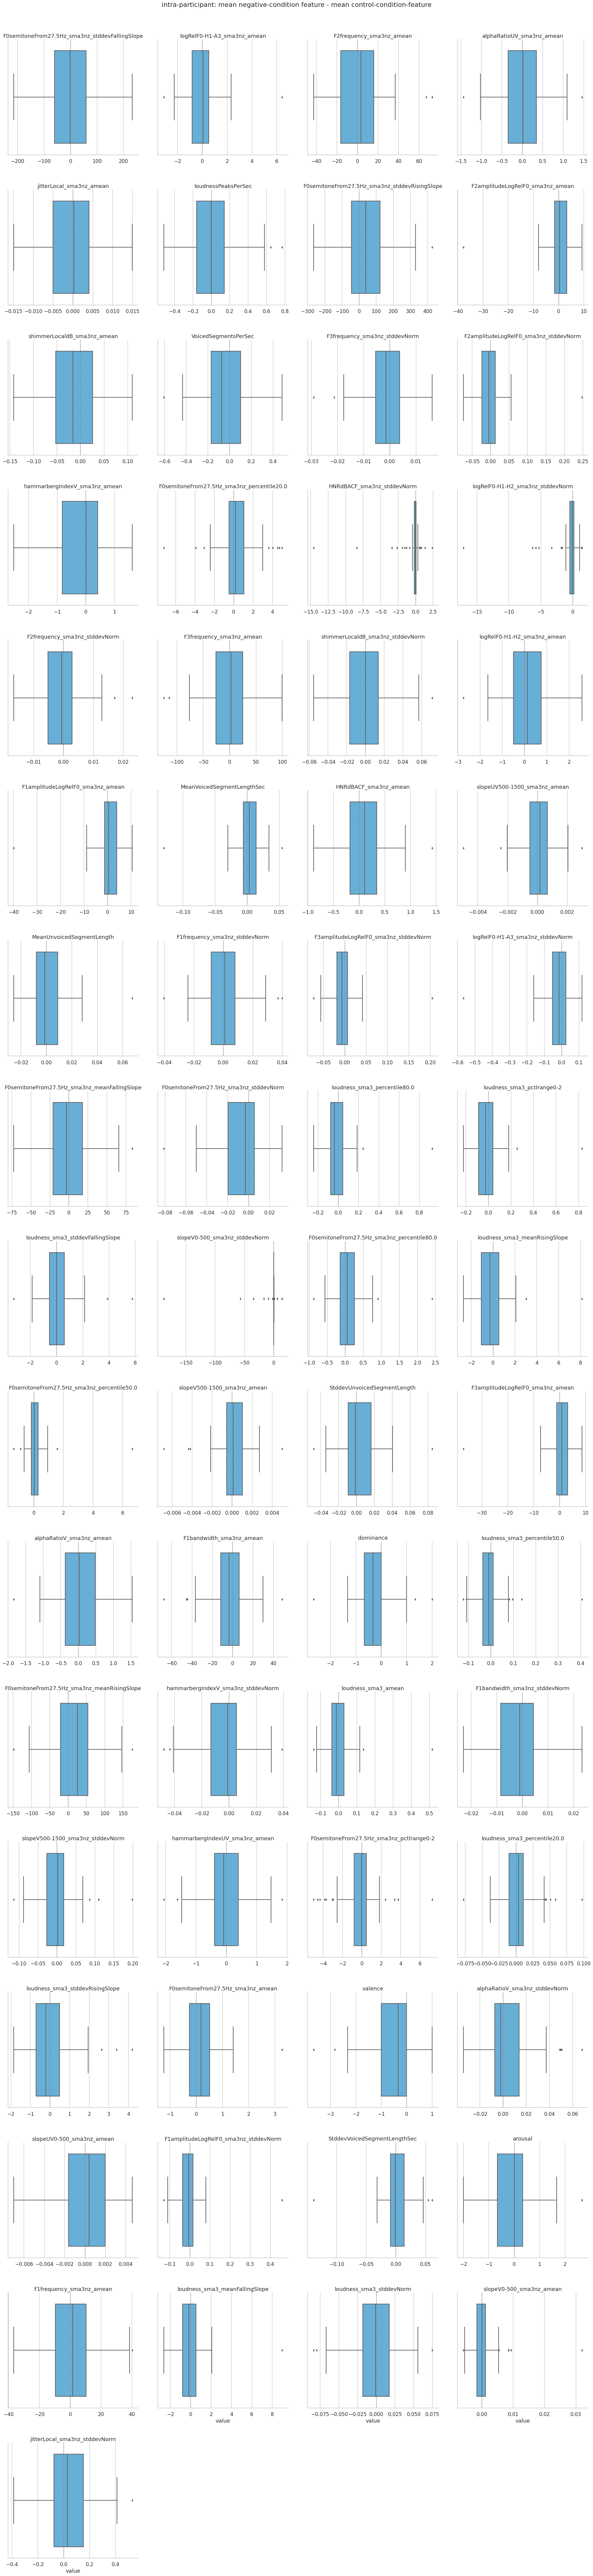

In [10]:
g = sns.catplot(
    data=mean_stress_min_contr_func[
        ~mean_stress_min_contr_func.index.isin(
            list(
                set(mean_stress_func.index)
                .difference(mean_contr_func.index)
                .union(set(mean_contr_func.index).difference(mean_stress_func.index))
            )
        )
    ].melt(),
    col="variable",
    x="value",
    kind="box",
    height=7,
    col_wrap=4,
    sharex=False,
    color="#56B4E9",
)
g.fig.suptitle(
    "intra-participant: mean negative-condition feature - mean"
    " control-condition-feature",
    y=1.01,
)
g.set_titles("{col_name}")
for ax in g.fig.axes:
    ax.axvline(x=0, color="grey", linestyle=":")
plt.subplots_adjust(wspace=0.15, hspace=0.3)


## `LLD's`: F0-range

### Condition comparison

In [11]:
qs = sum([[1 - q, q] for q in [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2]], [])
q_med = [0.5]

In [12]:
for sig in ["F0final_sma", "F0semitoneFrom27.5Hz_sma3nz"]:
    for (max_q, min_q) in list(zip(qs[::2], qs[1::2])):
        max_q_col = "_".join([sig, f"q={max_q}"])
        min_q_col = "_".join([sig, f"q={min_q}"])

        df_feat_tot[f"{sig}_qd={max_q}-{min_q}"] = (
                df_feat_tot[max_q_col] - df_feat_tot[min_q_col]
        )

/users/jonvdrdo/.cache/pypoetry/virtualenvs/speech-study-3baMn38--py3.8/lib/python3.8/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


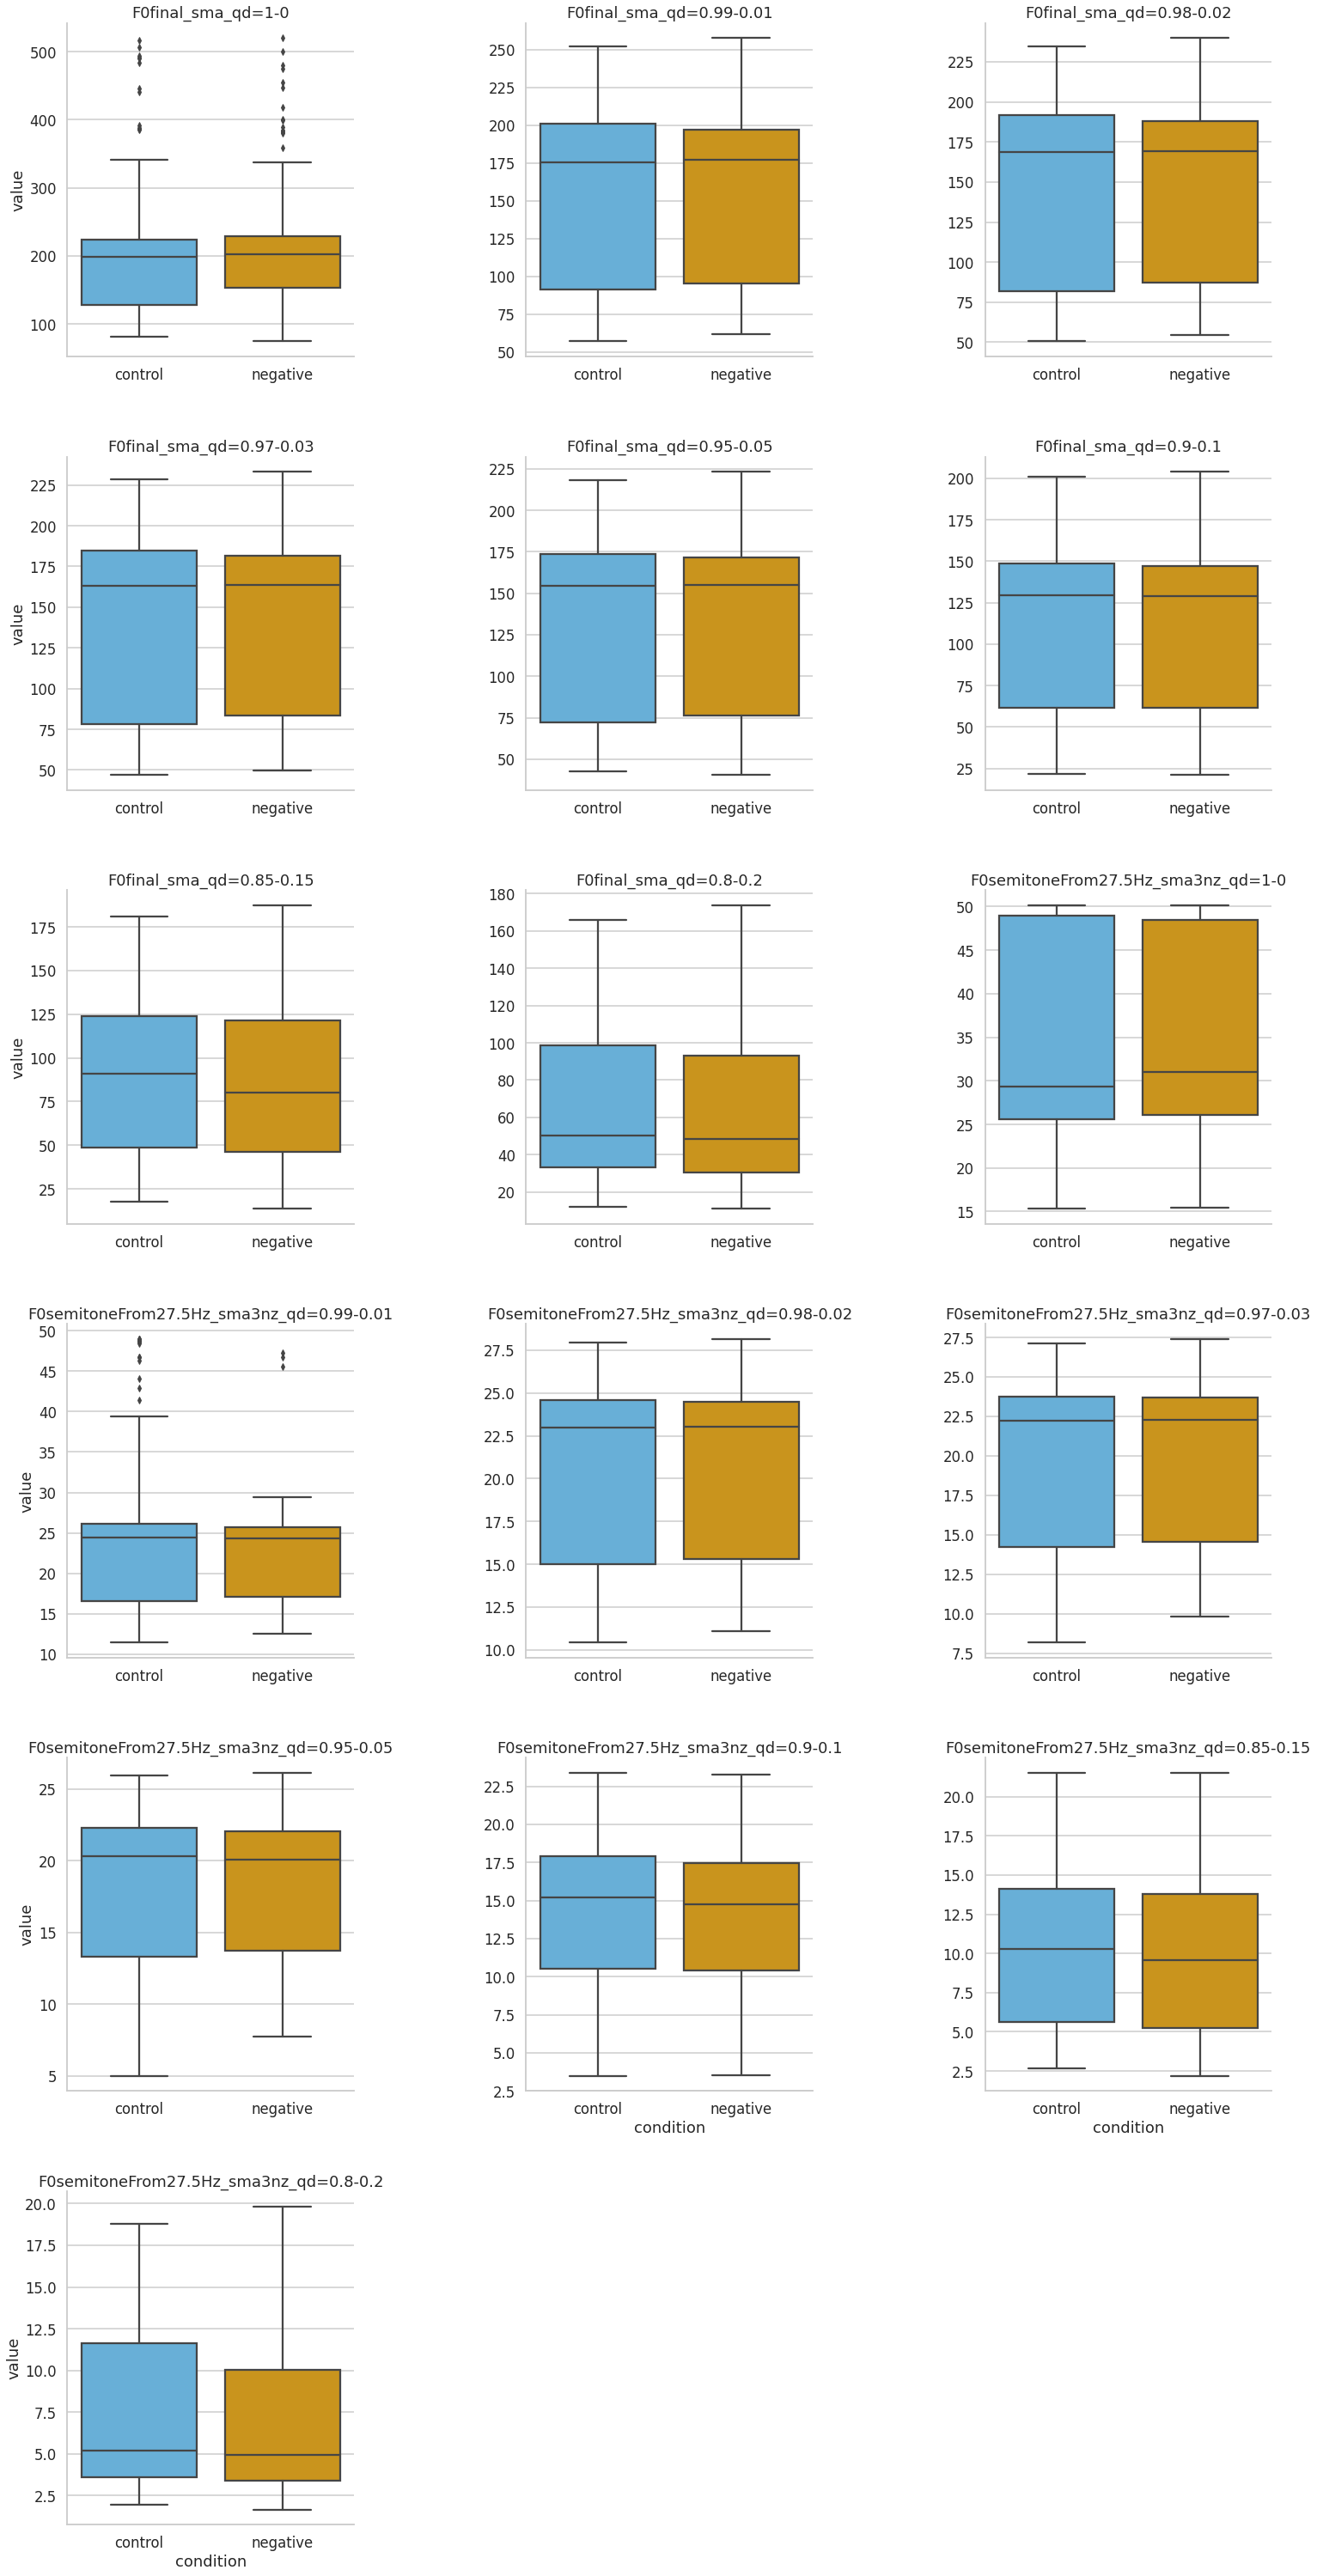

In [13]:
g = sns.catplot(
    data=pd.melt(
        frame=df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.condition.notna())],
        id_vars=["file", "fileName", "fileNum", "condition", "participantNum"],
        value_vars=list(df_feat_tot.filter(like="qd=").columns.values),
        value_name="value",
        var_name="f_name",
    ),
    x="condition",
    y="value",
    col="f_name",
    col_wrap=3,
    height=7,
    sharey=False,
    kind="box",
    sharex=False,
    palette=["#56B4E9", "#E69F00"],

)
g.set_titles("{col_name}")
plt.subplots_adjust(wspace=0.6, hspace=0.3)

### Per participant difference plot

In [14]:
# calculate the mean per participant, per condition
# TODO -> maybe use the reference values? and subtract the control / negative-feedback
#  condition from these reference values
mean_func = (
    df_feat_tot[(~df_feat_tot.bad_audio) & (df_feat_tot.condition.notna())]
        .groupby(["participantNum", "condition"])
        .mean()
        .reset_index()
)
mean_contr_func = mean_func[mean_func.condition == "control"].set_index(
    "participantNum")
mean_stress_func = mean_func[mean_func.condition == "negative"].set_index(
    "participantNum")
feat_cols: List[str] = list(df_feat_tot.filter(like="qd=").columns.values)

mean_stress_min_contr_func = mean_stress_func[feat_cols] - mean_contr_func[feat_cols]

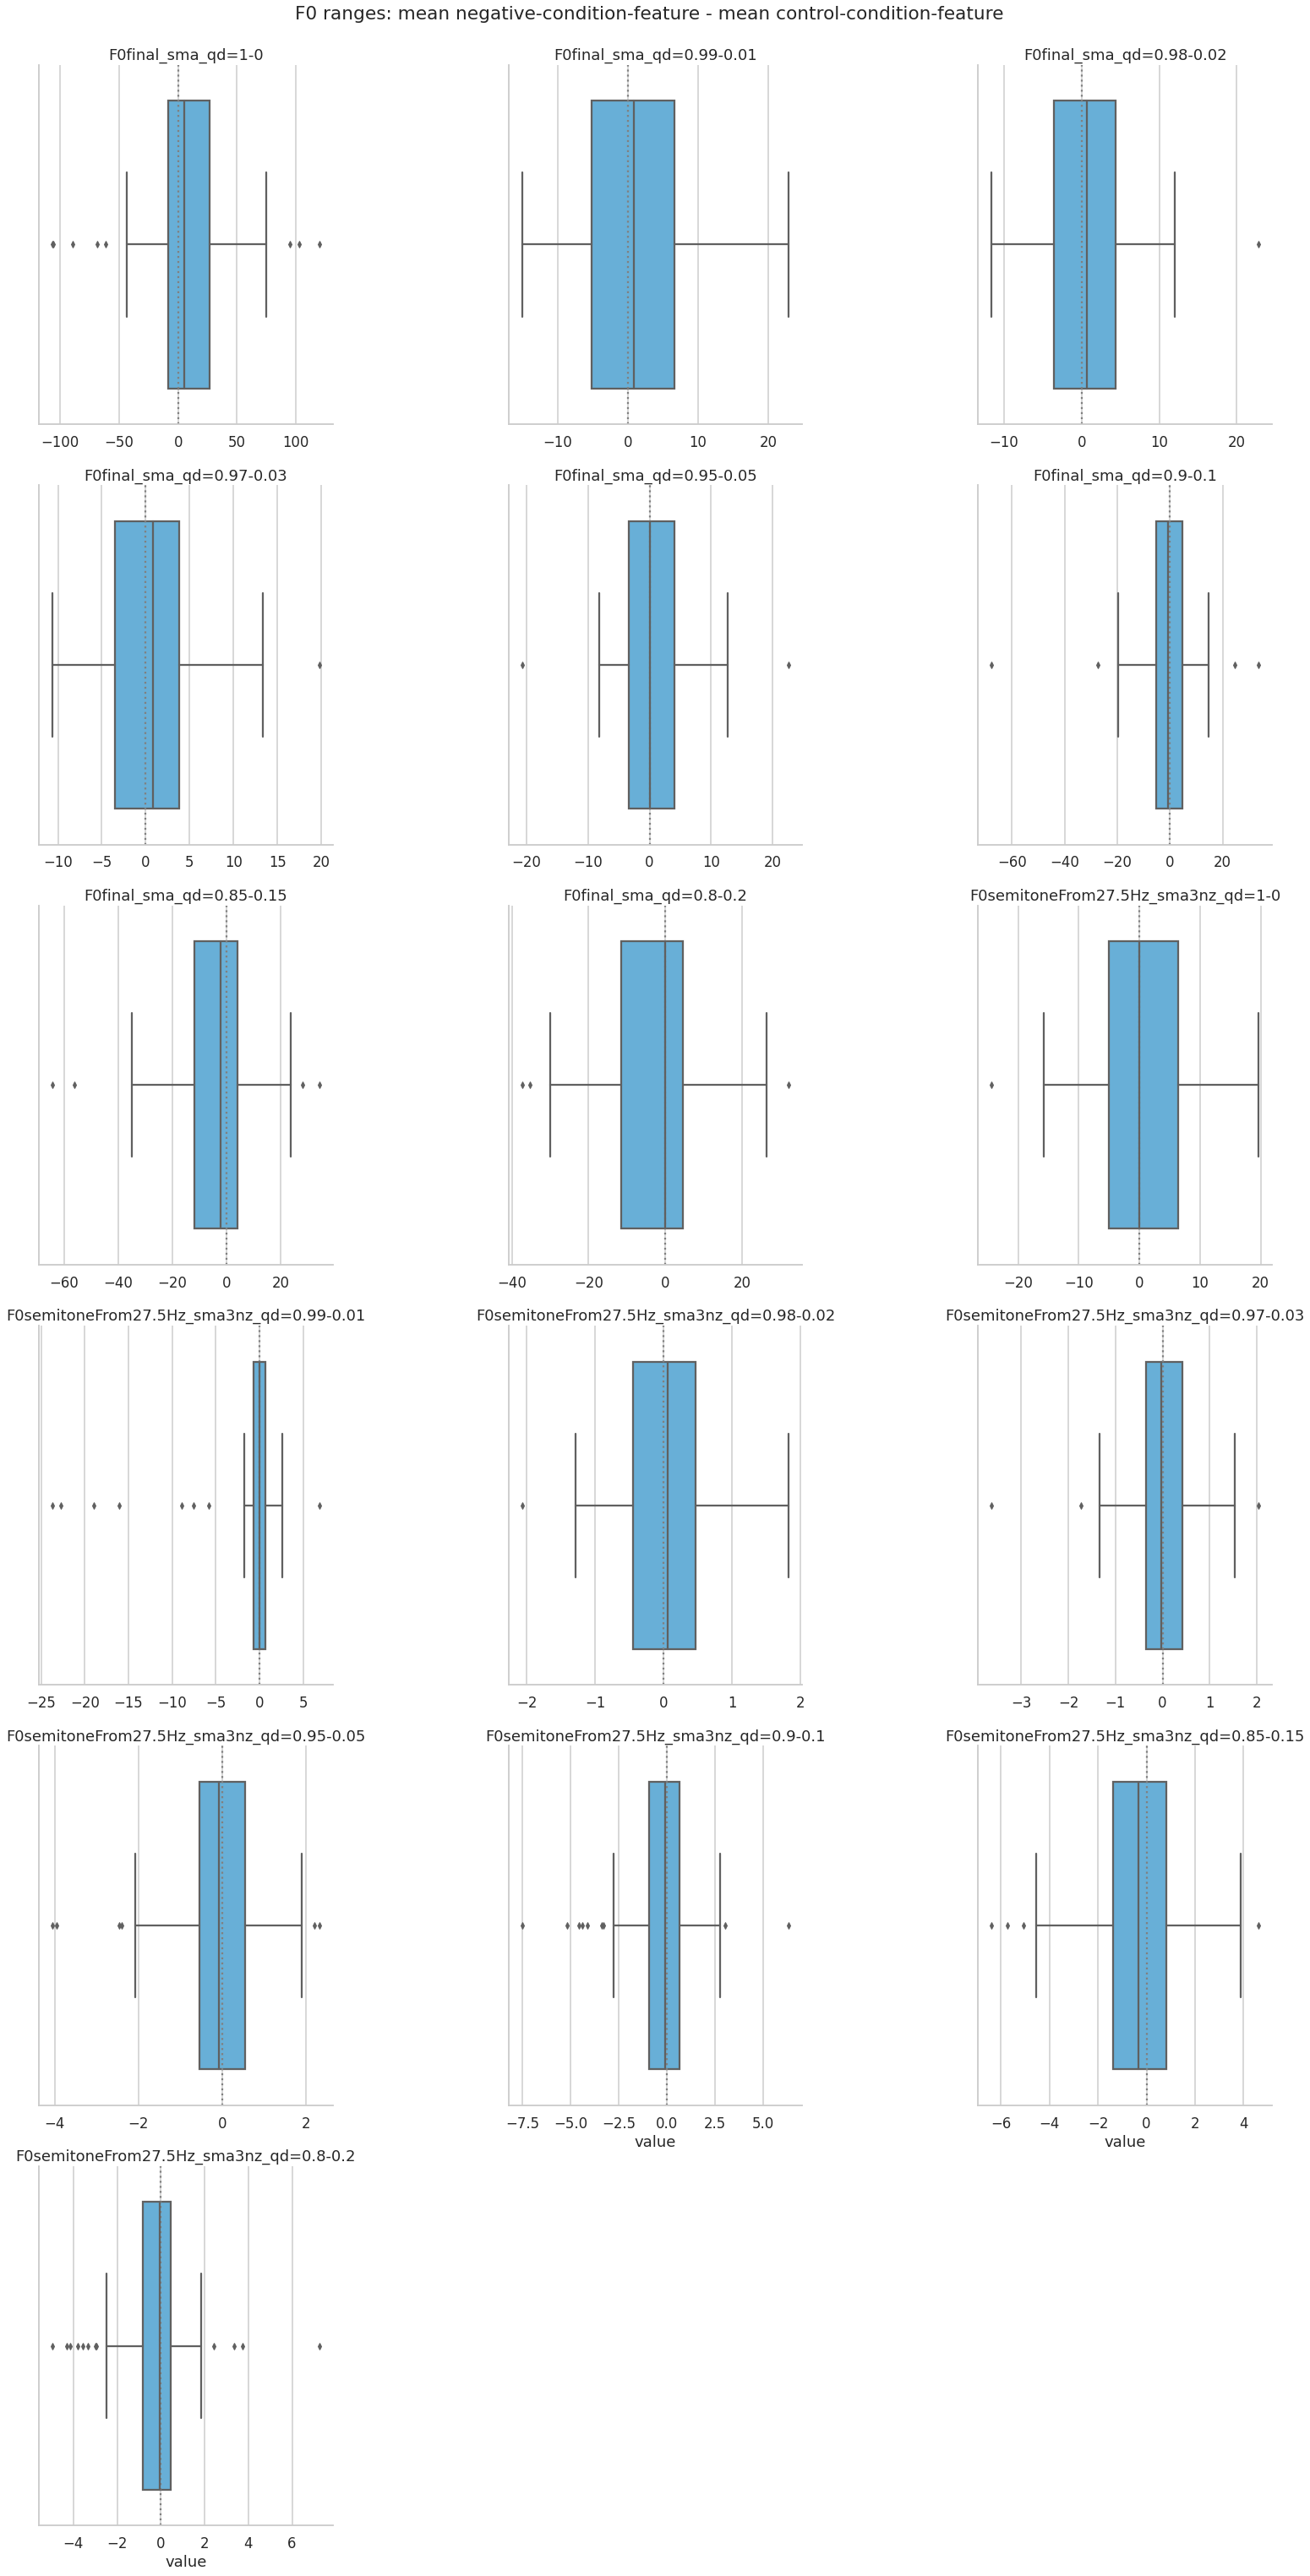

In [15]:
g = sns.catplot(
    data=mean_stress_min_contr_func[
        ~mean_stress_min_contr_func.index.isin(
            list(
                set(mean_stress_func.index)
                    .difference(mean_contr_func.index)
                    .union(
                    set(mean_contr_func.index).difference(mean_stress_func.index))
            )
        )
    ].melt(),
    col="variable",
    x="value",
    kind="box",
    height=7,
    col_wrap=3,
    sharex=False,
    color="#56B4E9"
)
g.set_titles("{col_name}")
g.fig.suptitle(
    "F0 ranges: mean negative-condition-feature - mean control-condition-feature",
    y=1.01
)
for ax in g.fig.axes:
    ax.axvline(x=0, color="grey", linestyle=":")
plt.subplots_adjust(wspace=0.6)